In [1]:
import pandas as pd
import numpy as np

import sqlite3
import json
import base64
import bitstring

import time
import datetime
from astral import Astral
from astral import  AstralGeocoder
from astral import  Location


import mpld3
import matplotlib.pyplot as plt

# 1. Import data

In [2]:
dbPath = 'db.sqlite'

In [3]:
con = sqlite3.connect(dbPath)
df = pd.read_sql_query("SELECT * from DATE_DATA", con)

In [4]:
df.tail()

,TYPE,SOURCE,DATE,SUMMARY,USER_SUMMARY,INDEXS,DATA,DATA_HR,SUMMARY_HR,SYNC,SYNC_QQHEALTH,TIME_ZONE,DEVICE_ID
968,0,5,2018-08-26,"{""v"":5,""slp"":{""st"":1535228460,""ed"":1535256180,...",None,None,"[{""start"":0,""stop"":1439,""value"":""BQAAFQAABQEAB...",None,None,1,0.0,12.0,88D367D105000333
969,0,5,2018-08-30,"{""v"":5,""slp"":{""st"":1535571540,""ed"":1535601300,...",None,None,"[{""start"":0,""stop"":1439,""value"":""BQAAFQAABQAAB...",None,None,1,0.0,12.0,88D367D105000333
970,0,5,2018-08-31,"{""v"":5,""slp"":{""st"":1535659800,""ed"":1535691480,...",None,None,"[{""start"":0,""stop"":1439,""value"":""BQAAFQAABQAAB...",None,None,1,0.0,12.0,88D367D105000333
971,0,5,2018-09-01,"{""v"":5,""slp"":{""st"":1535752440,""ed"":1535778780,...",None,None,"[{""start"":0,""stop"":1439,""value"":""AC4AEC0AACMAA...",None,None,1,0.0,12.0,88D367D105000333
972,0,5,2018-09-02,"{""v"":5,""slp"":{""st"":1535837940,""ed"":1535867460,...",None,None,"[{""start"":0,""stop"":1439,""value"":""EAIAABIAAAwAA...",None,None,0,0.0,12.0,88D367D105000333


In [6]:
len(df)

973

## 1.1 Extract summary

In [7]:
#old format
#u'{"slp":{"usrEd":-1440,"lt":447,"st":1464723180,"wk":0,"dp":10,"usrSt":-1440,"ed":1464750600},
#"v":5,"goal":8000,
#"stp":{"rn":0,"cal":237,"runDist":0,"wk":61,"ttl":5071,"runCal":0,"dis":4050}}'

#new format
#u'{"slp":{"lt":0,"st":1441400400,"wk":0,"dp":0,"ed":1441400400},
#"v":5,"goal":8000,
#"stp":{"rn":0,"cal":30,"runDist":6,"wk":13,"ttl":619,"runCal":0,"dis":428}}'

def extractSummary(summaryJson):
    s=json.loads(summaryJson)
    return \
    s['slp']['usrEd'] if "usrEd" in s['slp'] else None, \
    s['slp']['lt'], \
    s['slp']['st'], \
    time.strftime("%H:%M", time.localtime(int(s['slp']['st']))), \
    s['slp']['wk'], \
    s['slp']['dp'], \
    s['slp']['usrSt'] if "usrSt" in s['slp'] else None,  \
    s['slp']['ed'], \
    time.strftime("%H:%M", time.localtime(int(s['slp']['ed']))), \
    s['v'], \
    s['goal'], \
    s['stp']['rn'], \
    s['stp']['cal'], \
    s['stp']['runDist'], \
    s['stp']['wk'], \
    s['stp']['ttl'], \
    s['stp']['runCal'], \
    s['stp']['dis'], \
    


In [8]:
   dfS = pd.DataFrame();

In [9]:
    dfS['s_usrEd'],\
    dfS['s_lt'], \
    dfS['s_st'], \
    dfS['s_st_t'], \
    dfS['s_wk'], \
    dfS['s_deep'], \
    dfS['s_usrSt'], \
    dfS['s_ed'], \
    dfS['s_ed_t'], \
    dfS['v'], \
    dfS['goal'], \
    dfS['a_rn'], \
    dfS['a_cal'], \
    dfS['a_runDist'], \
    dfS['a_wk'], \
    dfS['a_ttl'], \
    dfS['a_runCal'], \
    dfS['a_dis'], \
=zip(*df['SUMMARY'].map(extractSummary))

In [10]:
dfS['DATE'] = df['DATE']

In [11]:
# s_lt - all sleep time (min)
# s_st - sleep begin time 


dfS.tail()

,s_usrEd,s_lt,s_st,s_st_t,s_wk,s_deep,s_usrSt,s_ed,s_ed_t,v,goal,a_rn,a_cal,a_runDist,a_wk,a_ttl,a_runCal,a_dis,DATE
968,-1440,320,1535228460,23:21,0,142,-1440,1535256180,07:03,5,5000,1,260,86,185,15869,1,10813,2018-08-26
969,-1440,334,1535571540,22:39,0,162,-1440,1535601300,06:55,5,5000,0,103,0,82,5757,0,3796,2018-08-30
970,-1440,335,1535659800,23:10,0,193,-1440,1535691480,07:58,5,5000,2,112,236,76,5984,6,4034,2018-08-31
971,-1440,248,1535752440,00:54,0,191,-1440,1535778780,08:13,5,5000,4,192,603,113,9865,16,6944,2018-09-01
972,-1440,292,1535837940,00:39,0,200,-1440,1535867460,08:51,5,5000,0,7,0,10,313,0,200,2018-09-02


## 1.1.2 Add extra columns

### 1.1.2.1 Add timestamp column

In [15]:
def convertToTimestamp(date):
    return int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()));

In [16]:
dfS['date_timestamp'] = dfS['DATE'].map(convertToTimestamp)

### 1.1.2.2 Convert sleep start time to minutes before midnight and wake up time to time after midnight

In [17]:
dfS['s_st_md'] = (dfS['date_timestamp'] - dfS['s_st']) / 60
dfS['s_ed_md'] = (dfS['date_timestamp'] - dfS['s_ed']) / 60

### 1.1.2.3 Add day of week

In [18]:
dfS['day'] = pd.to_datetime(dfS['DATE']).dt.dayofweek
dfS['week_number'] =  pd.to_datetime(dfS['DATE']).dt.week

### 1.1.2.4 And sunrise/sunset time

In [22]:
l = Location()
l.name = 'Novocherkassk'
l.latitude = 47.2609
l.longitude = 40.0555
l.timezone = 'Europe/Moscow'
l.elevation = 0
l.sun();

In [22]:
sun = l.sun(date = datetime.datetime.fromtimestamp(1465333200), local = True)

In [23]:
def getSunRiseSet(l, ts):
    sun = l.sun(date = datetime.datetime.fromtimestamp(ts), local = True);
    ss = (int(time.mktime(sun['sunset'].timetuple())) - (ts) - 60 * 60 * 24) / 60;
    sr = (int(time.mktime(sun['sunrise'].timetuple())) - ts) / 60;
    return ss, sr;

In [24]:
getSsSrSPb = lambda x: getSunRiseSet(l, x)

In [25]:
getSunRiseSet(l, 1465333200)

(-226.56666666666666, 264.21666666666664)

In [26]:
dfS['sunset'], dfS['sunrise'] = zip(*dfS['date_timestamp'].map(getSsSrSPb))

In [27]:
dfS.tail()

,s_usrEd,s_lt,s_st,s_st_t,s_wk,s_deep,s_usrSt,s_ed,s_ed_t,v,...,a_runCal,a_dis,DATE,date_timestamp,s_st_md,s_ed_md,day,week_number,sunset,sunrise
968,-1440,320,1535228460,23:21,0,142,-1440,1535256180,07:03,5,...,1,10813,2018-08-26,1535230800,39.0,-423.0,6,34,-286.866667,330.350000
969,-1440,334,1535571540,22:39,0,162,-1440,1535601300,06:55,5,...,0,3796,2018-08-30,1535576400,81.0,-415.0,3,35,-294.483333,335.616667
970,-1440,335,1535659800,23:10,0,193,-1440,1535691480,07:58,5,...,6,4034,2018-08-31,1535662800,50.0,-478.0,4,35,-296.400000,336.933333
971,-1440,248,1535752440,00:54,0,191,-1440,1535778780,08:13,5,...,16,6944,2018-09-01,1535749200,-54.0,-493.0,5,35,-298.350000,338.266667
972,-1440,292,1535837940,00:39,0,200,-1440,1535867460,08:51,5,...,0,200,2018-09-02,1535835600,-39.0,-531.0,6,35,-300.300000,339.583333


## 1.2 Extract RAW

### 1.2.1  Extract activity and sleep RAW data

In [72]:
#u'[{"value":"BRQAFQAABQA ... ABQAA","did":"88EC252D04000427","stop":1439,"src":4,"tz":12,"start":0}]'

def extractRawData(rawData):
    if rawData:
        r = json.loads(rawData)
        value = r[0]['value']
        f = base64.b64decode(value)
        return [[a, b, c] for a, b, c in zip(*[iter(f)] * 3)]
    else:
        return [[None, None, None]] * 1440;

### 1.2.2 Extract Heart Rate data

In [73]:
def extractRawDataHR(rawData):
    if rawData:
        return list(bytearray(rawData));
    else:
        return [None] * 1440;

### 1.2.3 Create data frames from Basic and Heart rate RAW data

In [74]:
def getRawDataDF(rawData, rawDataHR, date):
    rawList = np.asarray(extractRawData(rawData));
    rawListHR = np.asarray(extractRawDataHR(rawDataHR));
    rawDate = np.asarray(range(int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple())),
                  int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple())) + 60 * 60 * 24, 60));
    return np.column_stack((np.column_stack((rawDate, rawList)), rawListHR));

### 1.2.4 Process and generate result data

In [75]:
resArray = getRawDataDF(df.DATA[0], df.DATA_HR[0], df.DATE[0])
resArray.shape
for r in range(1, df.shape[0]):
    resArray = np.vstack((resArray, getRawDataDF(df.DATA[r], df.DATA_HR[r], df.DATE[r])))

In [76]:
len(resArray)

1401120

### 1.2.5 Create RAW data with timestamp as index

In [77]:
dfRaw = pd.DataFrame(resArray, index = pd.to_datetime(resArray[:, 0], unit = 's').tz_localize('UTC').tz_convert('Europe/Moscow'), columns=['timestamp', 'activity1', 'activity2', 'activity3', 'pulse'])

In [78]:
dfRawRed = dfRaw.dropna(subset = ['activity1'])

In [79]:
dfRawRed.shape

(571680, 5)

In [80]:
dfRawRed.tail()

,timestamp,activity1,activity2,activity3,pulse
2018-09-02 23:55:00+03:00,1535921700,126,0,0,None
2018-09-02 23:56:00+03:00,1535921760,126,0,0,None
2018-09-02 23:57:00+03:00,1535921820,126,0,0,None
2018-09-02 23:58:00+03:00,1535921880,126,0,0,None
2018-09-02 23:59:00+03:00,1535921940,126,0,0,None


In [81]:
#relation between s_lt and other fields
#dfS['s_lt_calc'] = dfS['s_st_md'] - dfS['s_ed_md'] - dfS['s_deep']

## 2. Compare application data, summary data and RAW data

In [82]:
def getDayFrame(date, df):
    ts1 = int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()));
    ts2 = ts1 + 60 * 60 * 24;
    return df[(df['timestamp'] >=  ts1) & (df['timestamp'] <= ts2)];

In [83]:
def getFrameByTS(ts1, ts2, df):
    return df[(df['timestamp'] >=  ts1) & (df['timestamp'] <= ts2)];

In [84]:
def getSumForDay(date, df):
    dayFrame = getDayFrame(date, df);
    return dayFrame['activity1'].sum(), dayFrame['activity2'].sum(), dayFrame['activity3'].sum();
    

In [90]:
dayFrame = getDayFrame('2018-06-06', dfRawRed);

### 2.1 Activity

<table>
<tr>
<td>
<img src="screenshots/Screenshot_2016-06-06-22-56-31.jpg"/>
</td>
<td>
<img src="screenshots/Screenshot_2016-06-06-22-55-41.jpg"/>
</td>
<td>
<img src="screenshots/Screenshot_2016-06-06-22-56-11.jpg"/>
</td>
<td>
<img src="screenshots/Screenshot_2016-06-06-22-56-22.jpg"/>
</td>
</tr>
</table>

###  Summary activity (steps) just sum of TTL data

In [88]:
# Get steps from RAW data
getSumForDay('2018-06-06', dfRawRed)

(2209, 19909, 1565)

### Activity plot — just TTL vs time

In [92]:
# Activity plot
fig = plt.figure()


ax = fig.add_subplot(111, facecolor = '#EEEEEE')
ax1 = fig.add_subplot(111, facecolor = '#EEEEEE')

ax.plot(dayFrame['activity3'].values, color = 'red')

#plt.show()
mpld3.display(fig)

C:\Users\Sacret\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Sleep

<img src="screenshots/Screenshot_2016-06-06-22-56-45.jpg" />

## Sleep time — s_ed - s_st summary data

In [95]:
sleepSec = np.float64(dfS.loc[363]['s_ed'] - dfS.loc[363]['s_st'])

In [96]:
 str(datetime.timedelta(seconds = sleepSec))

'10:39:00'

In [98]:
deepSleepSec = np.float64(dfS.loc[363]['s_deep'])

In [99]:
 str(datetime.timedelta(seconds = deepSleepSec))

'0:04:30'

In [102]:
lightSleepSec = np.float64(dfS.loc[363]['s_lt'])

In [103]:
 str(datetime.timedelta(seconds = lightSleepSec))

'0:05:29'

### RAW data and sleep

In [104]:
dfS.loc[363]

s_usrEd                -1440
s_lt                     329
s_st              1483127220
s_st_t                 22:47
s_wk                      40
s_deep                   270
s_usrSt                -1440
s_ed              1483165560
s_ed_t                 09:26
v                          5
goal                    5000
a_rn                      19
a_cal                    326
a_runDist               2130
a_wk                      75
a_ttl                   8389
a_runCal                  86
a_dis                   5909
DATE              2016-12-31
date_timestamp    1483131600
s_st_md                   73
s_ed_md                 -566
day                        5
week_number               52
sunset              -441.117
sunrise                486.6
Name: 363, dtype: object

### Value 4 - light sleep? No

In [105]:
dayFrame[(dayFrame['activity1'] > 0) & (dayFrame['activity1'] <= 4)]['timestamp'].count() # != s_lt

72

### Value 5 - deep sleep? No

In [106]:
dayFrame[(dayFrame['activity1'] == 5)]['timestamp'].count()

347

### < 100 sleep ? No

In [107]:
dayFrame[(dayFrame['activity1'] > 0) & (dayFrame['activity1'] <= 100)]['timestamp'].count() # != s_lt

432

In [108]:
dfS.loc[363]['s_lt'] + dfS.loc[363]['s_deep']

599

### Data between sleep start and wake up = sleep time? No

In [109]:
dayFrameTR = dayFrame[(dayFrame['timestamp'] >= 1465160160) & (dayFrame['timestamp'] <= 1465180620)]

In [110]:
dayFrameTR[(dayFrameTR['activity1'] > 0) & (dayFrameTR['activity1'] <= 100)]['timestamp'].count()

0

### Sleep time diagram

C:\Users\Sacret\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


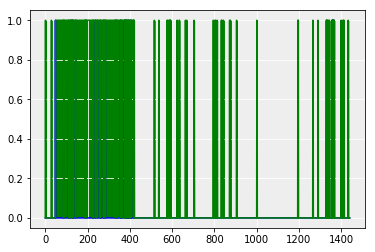

In [141]:
%matplotlib inline
# Histogram with modified axes/grid
fig = plt.figure()

ordSleep = ((dayFrame['activity1'] != 4) & (dayFrame['activity1'] != 4) & ((dayFrame['activity1'] > 0) & (dayFrame['activity1'] < 100))).values

ax = fig.add_subplot(111, facecolor = '#EEEEEE')
ax1 = fig.add_subplot(111, facecolor = '#EEEEEE')
ax2 = fig.add_subplot(111, facecolor = '#EEEEEE')
ax.grid(color = 'white', linestyle = 'solid')
ax1.grid(color = 'white', linestyle = 'solid')
ax2.grid(color = 'white', linestyle = 'solid')
ax.plot((dayFrame['activity1'] == 4).values, color = 'blue');
ax1.plot(ordSleep, color = 'green');
ax1.fill_between(range(0, dayFrame.shape[0]), ordSleep, color = 'green')


# mpld3.display(fig)
mpld3.disable_notebook()

### Sleep bytes (activity1) by hours

In [113]:
%matplotlib inline
# Histogram with modified axes/grid
fig = plt.figure()


m_hours = dayFrame.index.hour

plt.plot(m_hours,dayFrame['activity1'].values, 'x', color = 'blue');
#plt.plot(m_hours, dayFrame['activity2'].values, color='green');
#ax1.fill_between(range(0,dayFrame.shape[0]), ordSleep, color='green')
plt.gcf().autofmt_xdate()

mpld3.display(fig)

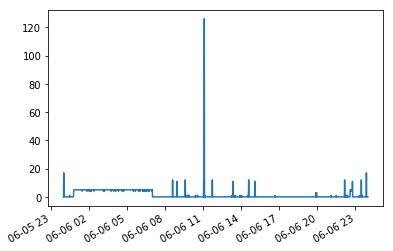

In [114]:
#mpld3.enable_notebook()
mpld3.disable_notebook()
dayFrame['activity1'].plot()

## 3. Analyze summary data

In [115]:
dfS.tail()

,s_usrEd,s_lt,s_st,s_st_t,s_wk,s_deep,s_usrSt,s_ed,s_ed_t,v,...,a_runCal,a_dis,DATE,date_timestamp,s_st_md,s_ed_md,day,week_number,sunset,sunrise
968,-1440,320,1535228460,23:21,0,142,-1440,1535256180,07:03,5,...,1,10813,2018-08-26,1535230800,39.0,-423.0,6,34,-286.866667,330.350000
969,-1440,334,1535571540,22:39,0,162,-1440,1535601300,06:55,5,...,0,3796,2018-08-30,1535576400,81.0,-415.0,3,35,-294.483333,335.616667
970,-1440,335,1535659800,23:10,0,193,-1440,1535691480,07:58,5,...,6,4034,2018-08-31,1535662800,50.0,-478.0,4,35,-296.400000,336.933333
971,-1440,248,1535752440,00:54,0,191,-1440,1535778780,08:13,5,...,16,6944,2018-09-01,1535749200,-54.0,-493.0,5,35,-298.350000,338.266667
972,-1440,292,1535837940,00:39,0,200,-1440,1535867460,08:51,5,...,0,200,2018-09-02,1535835600,-39.0,-531.0,6,35,-300.300000,339.583333


## 3.1 Check simple dependencies

## Activity vs sleep

In [116]:
%matplotlib inline
mpld3.enable_notebook()

 * **Activity vs all sleep**

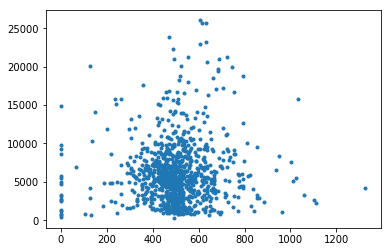

In [117]:
plt.plot((dfS['s_deep'] + dfS['s_lt']).values, dfS['a_ttl'].values, '.')

* **Activity vs deep sleep**

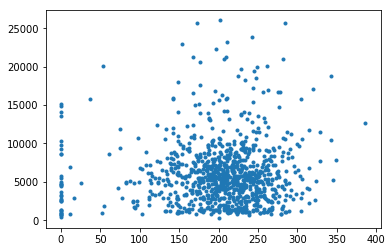

In [118]:
plt.plot(dfS['s_deep'].values, dfS['a_ttl'].values, '.')

## Sleep vs activity

In [119]:
ttlShifted = np.append(np.delete(dfS['a_ttl'].values, 0), 0)

 * **Deep sleep vs activity**

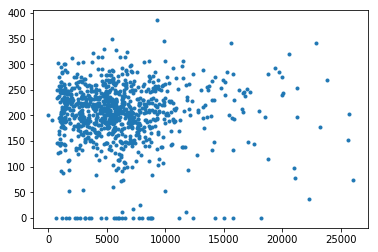

In [120]:
plt.plot(ttlShifted, dfS['s_deep'].values, '.')

 * **All sleep vs activity**

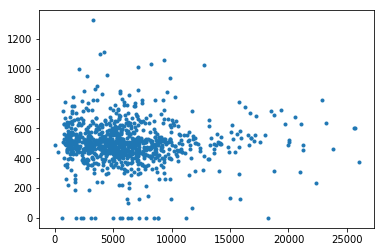

In [121]:
plt.plot(ttlShifted, (dfS['s_deep'] + dfS['s_lt']).values, '.')

## Sleep ratio vs activity before

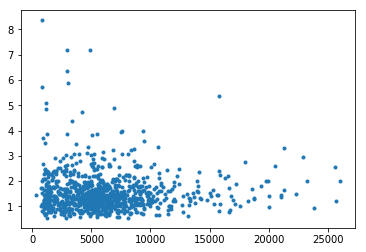

In [122]:
plt.plot(dfS['a_ttl'].values, (dfS['s_lt'] / dfS['s_deep']).values, '.')

## Sleep ratio vs activity after

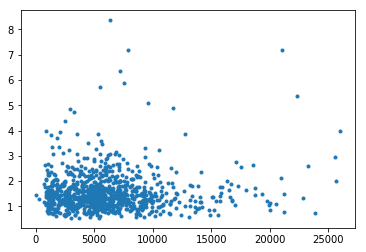

In [123]:
plt.plot(ttlShifted, (dfS['s_lt'] / dfS['s_deep']).values, '.')

## Deep sleep vs sleep begin time (until midnight)

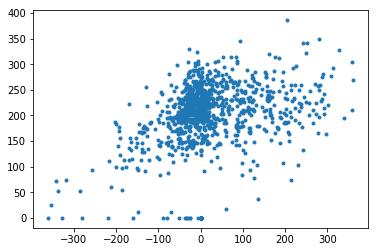

In [124]:
plt.plot(dfS['s_st_md'].values, dfS['s_deep'].values, '.')

## Sleep ratio vs sleep begin time (until midnight)

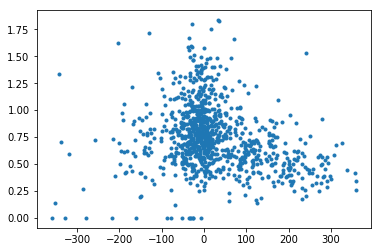

In [125]:
plt.plot(dfS['s_st_md'].values, (dfS['s_deep'] / dfS['s_lt']).values, '.')

### Deep sleep vs light sleep

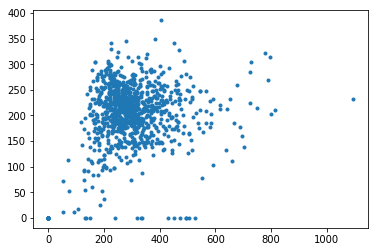

In [142]:
plt.plot(dfS['s_lt'].values, dfS['s_deep'].values, '.')

### Activity on wake up time

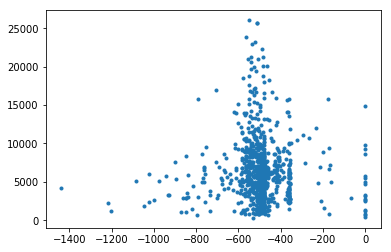

In [143]:
plt.plot(dfS['s_ed_md'].values, dfS['a_ttl'].values, '.')

### Sleep ratio vs activity

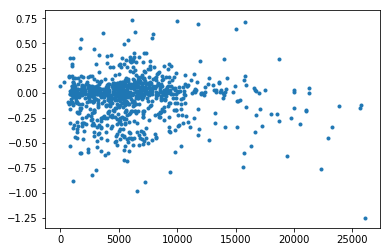

In [144]:
plt.plot(ttlShifted, (dfS['s_st_md'] / dfS['s_ed_md']).values, '.')

### Sleep begin time vs sunset time

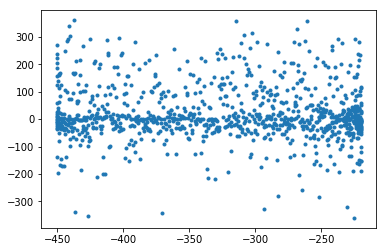

In [145]:
plt.plot(dfS['sunset'].values, dfS['s_st_md'].values, '.')

### Wake up time vs sunrise

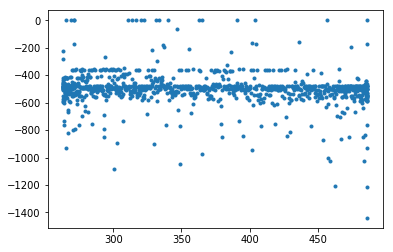

In [146]:
plt.plot(dfS['sunrise'].values, dfS['s_ed_md'].values, '.')

### Aggregation by week number

In [147]:
dfSByWeekMean = dfS.groupby('week_number').mean()
dfSByWeekMax = dfS.groupby('week_number').max()
dfSByWeekMin = dfS.groupby('week_number').min()

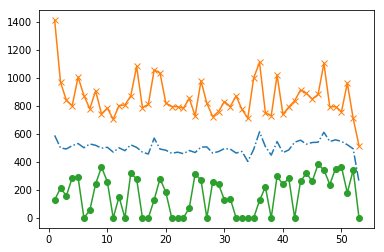

In [148]:
plt.plot(dfSByWeekMean.index.values, (dfSByWeekMean['s_deep'] + dfSByWeekMean['s_lt']).values, '-.',
        dfSByWeekMax.index.values, (dfSByWeekMax['s_deep'] + dfSByWeekMax['s_lt']).values, '-x',
        dfSByWeekMin.index.values, (dfSByWeekMin['s_deep'] + dfSByWeekMin['s_lt']).values, '-o')

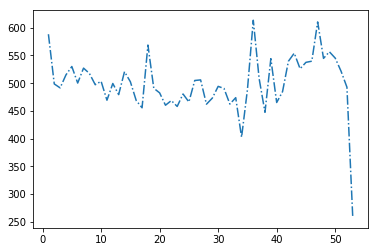

In [149]:
plt.plot(dfSByWeekMean.index.values, (dfSByWeekMean['s_deep'] + dfSByWeekMean['s_lt']).values, '-.')

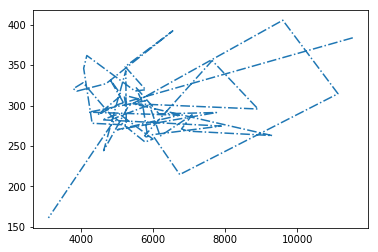

In [150]:
plt.plot(dfSByWeekMean['a_ttl'].values, dfSByWeekMean['s_lt'].values, '-.')

## Sleep on week day

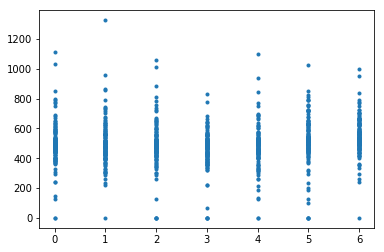

In [151]:
plt.plot(dfS['day'], (dfS['s_deep'] + dfS['s_lt']).values, '.')

## Aggregation by day number

In [152]:
dfSBydayMean = dfS.groupby('day').mean()
dfSBydayMax = dfS.groupby('day').max()
dfSBydayMin = dfS.groupby('day').min()

### Sleep vs day of week

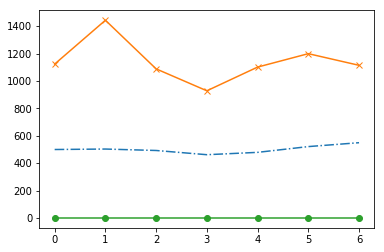

In [153]:
plt.plot(dfSBydayMean.index.values, (dfSBydayMean['s_deep'] + dfSBydayMean['s_lt']).values, '-.',
        dfSBydayMax.index.values, (dfSBydayMax['s_deep'] + dfSBydayMax['s_lt']).values, '-x',
        dfSBydayMin.index.values, (dfSBydayMin['s_deep'] + dfSBydayMin['s_lt']).values, '-o')

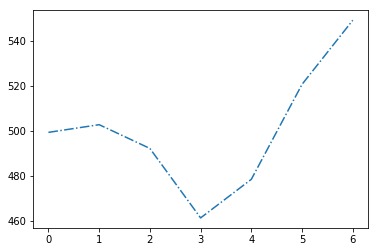

In [154]:
plt.plot(dfSBydayMean.index.values, (dfSBydayMean['s_deep'] + dfSBydayMean['s_lt']).values, '-.')

### Activity vs day of week

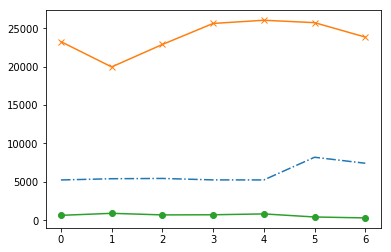

In [155]:
plt.plot(dfSBydayMean.index.values, dfSBydayMean['a_ttl'].values, '-.',
        dfSBydayMax.index.values, dfSBydayMax['a_ttl'].values, '-x',
        dfSBydayMin.index.values, dfSBydayMin['a_ttl'].values, '-o')

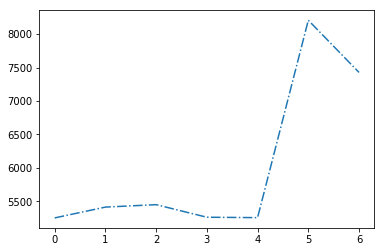

In [156]:
plt.plot(dfSBydayMean.index.values, dfSBydayMean['a_ttl'].values, '-.')

## Simple in-time period analyze

In [157]:
dfS['datetime'] = pd.to_datetime(dfS['DATE']);

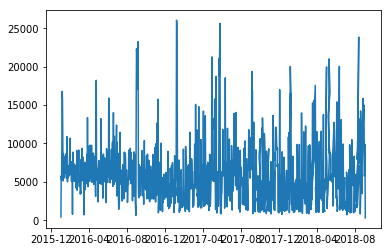

In [158]:
plt.plot(dfS['datetime'].values, dfS['a_ttl'].values)

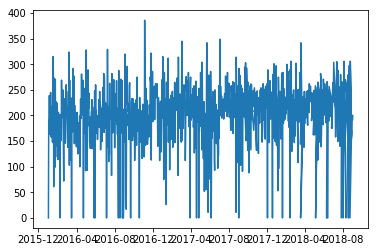

In [159]:
plt.plot(dfS['datetime'].values, dfS['s_deep'].values)

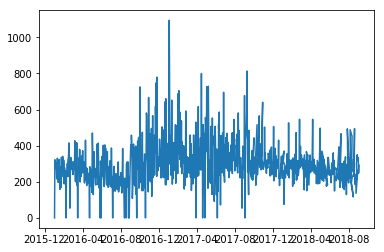

In [160]:
plt.plot(dfS['datetime'].values, dfS['s_lt'].values)

### Sleep ratio prediction with Linear regression

In [161]:
dfS.columns

Index(['s_usrEd', 's_lt', 's_st', 's_st_t', 's_wk', 's_deep', 's_usrSt',
       's_ed', 's_ed_t', 'v', 'goal', 'a_rn', 'a_cal', 'a_runDist', 'a_wk',
       'a_ttl', 'a_runCal', 'a_dis', 'DATE', 'date_timestamp', 's_st_md',
       's_ed_md', 'day', 'week_number', 'sunset', 'sunrise', 'datetime'],
      dtype='object')

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

C:\Users\Sacret\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [163]:
dfSML = dfS[(dfS['s_lt'] != 0) & (dfS['s_deep'] != 0)]


In [164]:
dfS.shape

(973, 27)

In [165]:
dfSML.shape

(941, 27)

In [166]:
X_columns = ['s_wk', 'a_ttl', 's_st_md', 's_ed_md']
Y_columns = 's_deep'

In [167]:
X = dfSML[X_columns]
y = dfSML['s_deep'] / dfSML['s_lt']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [169]:
clf = LinearRegression(normalize = True)

In [170]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [171]:
clf.coef_

array([-1.95424577e-03, -1.96306038e-06, -4.41335434e-04,  2.80184721e-04])

In [172]:
y_pred = clf.predict(X_test)

In [173]:
scores = cross_val_score(LinearRegression(normalize = True), X_train, y_train,
                         cv = KFold(len(X_train), n_folds = 5, shuffle = True, random_state = 241))

In [174]:
scores.mean()

0.1640836460800498

## So, we have very very poor prediction — we can't predict sleep ratio

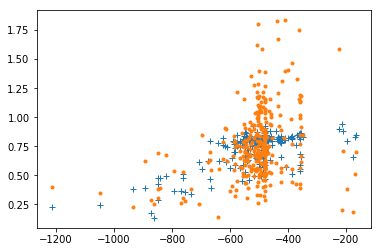

In [175]:
plt.plot(X_test['s_ed_md'].values, y_pred, '+', X_test['s_ed_md'].values, y_test, '.')

### Add extra columns and repeat prediction

In [176]:
dfS.columns

Index(['s_usrEd', 's_lt', 's_st', 's_st_t', 's_wk', 's_deep', 's_usrSt',
       's_ed', 's_ed_t', 'v', 'goal', 'a_rn', 'a_cal', 'a_runDist', 'a_wk',
       'a_ttl', 'a_runCal', 'a_dis', 'DATE', 'date_timestamp', 's_st_md',
       's_ed_md', 'day', 'week_number', 'sunset', 'sunrise', 'datetime'],
      dtype='object')

In [177]:
X_columns = ['s_wk', 'a_ttl', 's_st_md', 's_ed_md', 'day', 'sunset', 'sunrise']

In [178]:
X = dfSML[X_columns]
y = dfSML['s_deep'] / dfSML['s_lt']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [180]:
scores = cross_val_score(LinearRegression(normalize = True), X_train, y_train,
                         cv = KFold(len(X_train), n_folds = 5, shuffle = True, random_state = 241))

In [181]:
scores.mean()

0.16766266621429055

## Little bit better prediction, but also very very poor

In [182]:
clf2 = LinearRegression(normalize = True)

In [183]:
clf2.fit(X_train, y_train)
clf2.coef_

array([-2.26685877e-03, -2.22227749e-06, -3.92354117e-04,  1.40578637e-04,
       -9.30846951e-03,  9.80152025e-04,  6.01771620e-04])

In [184]:
y_pred2 = clf2.predict(X_test)

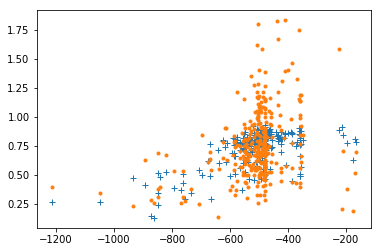

In [185]:
plt.plot(X_test['s_ed_md'].values, y_pred2, '+', X_test['s_ed_md'].values, y_test, '.')

### Add polynomial features

In [186]:
from sklearn.preprocessing import PolynomialFeatures

In [187]:
poly = PolynomialFeatures(2)
X2 = poly.fit_transform(X)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.33, random_state = 42)

In [189]:
scores = cross_val_score(LinearRegression(normalize = True), X_train, y_train,
                         cv = KFold(len(X_train), n_folds = 5, shuffle = True, random_state = 241))
scores.mean()

0.0996005927706078

### Overfitting?

In [190]:
X2.shape

(941, 36)

In [191]:
clf2.fit(X_train, y_train)
clf2.coef_

array([-2.21096409e-13, -1.33412240e-02,  1.78894649e-05,  7.39980333e-04,
       -1.47277633e-03, -5.11211110e-02,  7.42507691e-03,  8.08134505e-03,
       -1.44051934e-05,  1.10220951e-07,  8.79384439e-06, -1.66870340e-05,
        2.99498493e-05,  2.24555209e-05,  2.45206749e-05, -4.61011397e-10,
        7.64377663e-10,  6.63896791e-09,  6.25770927e-07,  4.67837692e-08,
        1.67122495e-08, -2.67233804e-06,  1.46600413e-06, -3.73440511e-05,
       -1.00699422e-06, -1.50592989e-06, -2.66586083e-06, -6.89515655e-05,
       -3.17515255e-07, -1.32760483e-06, -4.40532961e-03,  1.36539948e-04,
        2.06956847e-04, -8.92906142e-06, -3.44809941e-05, -2.65690122e-05])

In [192]:
y_pred2 = clf2.predict(X_test)

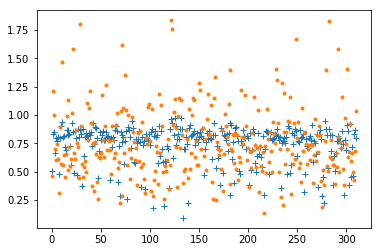

In [193]:
plt.plot(range(len(y_pred2)), y_pred2, '+', range(len(y_pred2)), y_test, '.')

## 4. Analyze RAW data

In [194]:
dfRawRed['pulse'].mean()

nan

In [195]:
dfRawRed.head()

,timestamp,activity1,activity2,activity3,pulse
2017-08-01 00:00:00+03:00,1501534800,0,24,0,None
2017-08-01 00:01:00+03:00,1501534860,16,13,0,None
2017-08-01 00:02:00+03:00,1501534920,0,2,0,None
2017-08-01 00:03:00+03:00,1501534980,0,11,0,None
2017-08-01 00:04:00+03:00,1501535040,0,0,0,None


### Add diff

In [197]:
dfRawRed['a1d'] = dfRawRed['activity1'].diff()
dfRawRed['a2d'] = dfRawRed['activity2'].diff()
dfRawRed['a3d'] = dfRawRed['activity3'].diff()
dfRawRed = dfRawRed.dropna(subset = ['a1d', 'a2d', 'a3d'])

C:\Users\Sacret\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Sacret\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Sacret\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [198]:
dfRawRed['day'] = pd.to_datetime(dfRawRed.index, unit = 's').dayofyear
dfRawRed['week_number'] = pd.to_datetime(dfRawRed.index, unit = 's').week
dfRawRed['hour'] =  pd.to_datetime(dfRawRed.index, unit = 's').hour
dfRawRed['DOfW'] =  pd.to_datetime(dfRawRed.index, unit = 's').dayofweek

### Hours aggregation

In [199]:
dfRawRed.activity1 = dfRawRed.activity1.astype(np.float64)
dfRawRed.activity2 = dfRawRed.activity2.astype(np.float64) 
dfRawRed.activity3 = dfRawRed.activity3.astype(np.float64)
dfRawRed.pulse = dfRawRed.pulse.astype(np.float64) 

In [200]:
dfRawRed.head()

,timestamp,activity1,activity2,activity3,pulse,a1d,a2d,a3d,day,week_number,hour,DOfW
2017-08-01 00:01:00+03:00,1501534860,16.0,13.0,0.0,NaN,16,-11,0,213,31,0,1
2017-08-01 00:02:00+03:00,1501534920,0.0,2.0,0.0,NaN,-16,-11,0,213,31,0,1
2017-08-01 00:03:00+03:00,1501534980,0.0,11.0,0.0,NaN,0,9,0,213,31,0,1
2017-08-01 00:04:00+03:00,1501535040,0.0,0.0,0.0,NaN,0,-11,0,213,31,0,1
2017-08-01 00:05:00+03:00,1501535100,0.0,20.0,0.0,NaN,0,20,0,213,31,0,1


In [201]:
dfRawByHourMean = dfRawRed.groupby('hour').mean()
dfRawByHourMax = dfRawRed.groupby('hour').max()
dfRawByHourMin = dfRawRed.groupby('hour').min()
dfRawByHourSum = dfRawRed.groupby('hour').sum()
dfRawByHourStd = dfRawRed.groupby('hour').std()

In [202]:
dfRawByHourMean.head()

,activity1,activity2,activity3,pulse,day,week_number,DOfW
hour,,,,,,,
0,3.129099,7.185860,1.007347,NaN,186.870440,27.067845,3.010160
1,4.798447,1.852855,0.232620,NaN,186.871537,27.068010,3.010076
2,5.130143,1.791268,0.312343,NaN,186.871537,27.068010,3.010076
3,5.141646,1.619479,0.157683,NaN,186.871537,27.068010,3.010076
4,5.149202,1.597145,0.078463,NaN,186.871537,27.068010,3.010076


### Mean/Max/Min steps aggregated hour column

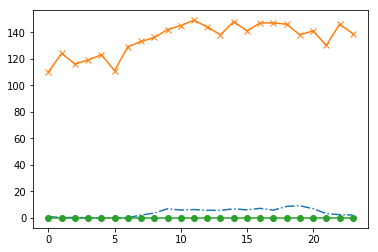

In [203]:
plt.plot(dfRawByHourMean.index.values, dfRawByHourMean['activity3'].values, '-.',label = 'steps mean (3th byte raw data)')
plt.plot(dfRawByHourMax.index.values, dfRawByHourMax['activity3'].values, '-x',label = 'steps max (3th byte raw data)')
plt.plot(dfRawByHourMin.index.values, dfRawByHourMin['activity3'].values, '-o',label = 'steps hour (3th byte raw data)')
#plt.legend(loc='upper left', shadow=True)

### Steps and scaled differential

In [204]:
plt.plot(dfRawByHourMean.index.values, dfRawByHourMean['activity3'].values * 60, '-.',
        dfRawByHourMean.index.values, dfRawByHourMean['a3d'].values * 1000, '-x')

KeyError: 'a3d'

### Sleep and scaled differential

In [205]:
plt.plot(dfRawByHourMean.index.values, dfRawByHourMean['activity1'].values, '-.',
        dfRawByHourMean.index.values, dfRawByHourMean['a1d'].values * 10, '-x')

KeyError: 'a1d'

### Second byte and differential

In [206]:
plt.plot(dfRawByHourMean.index.values, dfRawByHourMean['activity2'].values, '-.',
        dfRawByHourMean.index.values, dfRawByHourMean['a2d'].values * 100, '-x')

KeyError: 'a2d'

### Activity +- Std

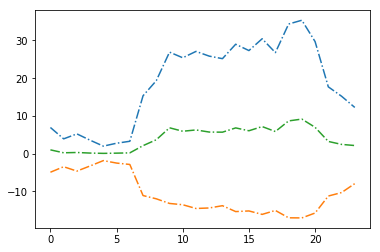

In [207]:
plt.plot(dfRawByHourStd.index.values, dfRawByHourMean['activity3'].values + dfRawByHourStd['activity3'].values, '-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity3'].values - dfRawByHourStd['activity3'].values, '-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity3'].values, '-.')

### Sleep +- Std

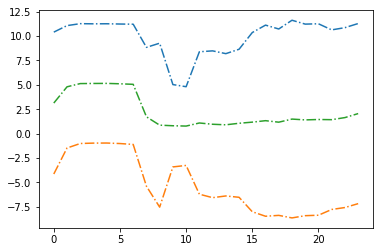

In [208]:
plt.plot(dfRawByHourStd.index.values, dfRawByHourMean['activity1'].values + dfRawByHourStd['activity1'].values, '-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity1'].values - dfRawByHourStd['activity1'].values, '-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity1'].values, '-.')

### Sleep/2d byte/Activity on same figure vs hours

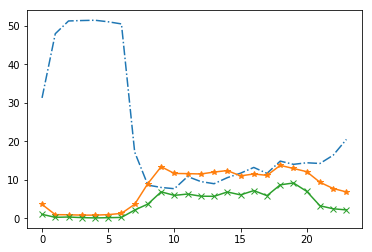

In [209]:
plt.plot(dfRawByHourStd.index.values, dfRawByHourMean['activity1'].values * 10, '-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity2'].values / 2, '-*',
        dfRawByHourStd.index.values, dfRawByHourMean['activity3'].values, '-x',
        dfRawByHourStd.index.values, dfRawByHourMean['pulse'].values / 10, '-')

### Day of year aggregation

In [210]:
dfRawByDayMean = dfRawRed.groupby('day').mean()
dfRawByDayMax = dfRawRed.groupby('day').max()
dfRawByDayMin = dfRawRed.groupby('day').min()
dfRawByDaySum = dfRawRed.groupby('day').sum()
dfRawByDayStd = dfRawRed.groupby('day').std()

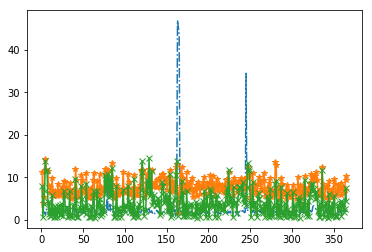

In [212]:
plt.plot(dfRawByDayStd.index.values, dfRawByDayMean['activity1'].values, '-.',
         # dfRawByDayStd.index.values, dfRawByDayMean['a1d'].values * 100, '-.',
        dfRawByDayStd.index.values, dfRawByDayMean['activity2'].values / 2, '-*',
        dfRawByDayStd.index.values, dfRawByDayMean['activity3'].values, '-x',
        dfRawByDayStd.index.values, dfRawByDayMean['pulse'].values / 10, '-')

### Week number aggregation

In [213]:
dfRawByWeekMean = dfRawRed.groupby('week_number').mean()
dfRawByWeekMax = dfRawRed.groupby('week_number').max()
dfRawByWeekMin = dfRawRed.groupby('week_number').min()
dfRawByWeekSum = dfRawRed.groupby('week_number').sum()
dfRawByWeekStd = dfRawRed.groupby('week_number').std()

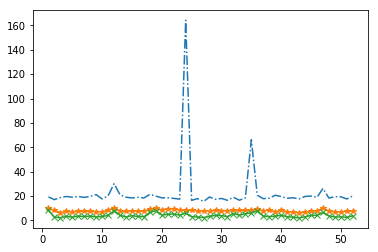

In [214]:
plt.plot(dfRawByWeekStd.index.values, dfRawByWeekMean['activity1'].values * 10, '-.',
        dfRawByWeekStd.index.values, dfRawByWeekMean['activity2'].values / 2,'-*',
        dfRawByWeekStd.index.values, dfRawByWeekMean['activity3'].values, '-x',
        dfRawByWeekStd.index.values, dfRawByWeekMean['pulse'].values / 10, '-')

### Day of week aggregation

In [215]:
dfRawByDOfWMean = dfRawRed.groupby('DOfW').mean()
dfRawByDOfWMax = dfRawRed.groupby('DOfW').max()
dfRawByDOfWMin = dfRawRed.groupby('DOfW').min()
dfRawByDOfWSum = dfRawRed.groupby('DOfW').sum()
dfRawByDOfWStd = dfRawRed.groupby('DOfW').std()

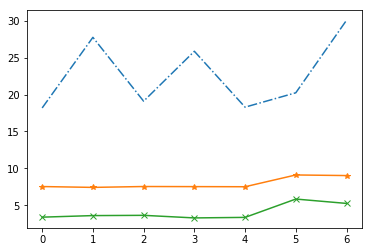

In [216]:
plt.plot(dfRawByDOfWStd.index.values, dfRawByDOfWMean['activity1'].values * 10, '-.',
        dfRawByDOfWStd.index.values, dfRawByDOfWMean['activity2'].values / 2, '-*',
        dfRawByDOfWStd.index.values, dfRawByDOfWMean['activity3'].values, '-x',
        dfRawByDOfWStd.index.values, dfRawByDOfWMean['pulse'].values / 10, '-')

## Cluster Analysis

In [217]:
from sklearn.cluster import KMeans

In [218]:
dfRawRed.head()

,timestamp,activity1,activity2,activity3,pulse,a1d,a2d,a3d,day,week_number,hour,DOfW
2017-08-01 00:01:00+03:00,1501534860,16.0,13.0,0.0,NaN,16,-11,0,213,31,0,1
2017-08-01 00:02:00+03:00,1501534920,0.0,2.0,0.0,NaN,-16,-11,0,213,31,0,1
2017-08-01 00:03:00+03:00,1501534980,0.0,11.0,0.0,NaN,0,9,0,213,31,0,1
2017-08-01 00:04:00+03:00,1501535040,0.0,0.0,0.0,NaN,0,-11,0,213,31,0,1
2017-08-01 00:05:00+03:00,1501535100,0.0,20.0,0.0,NaN,0,20,0,213,31,0,1


In [219]:
y_pred = KMeans(n_clusters = 4, random_state = 241).fit_predict(dfRawByHourMean[['activity1', 'a1d', 'a2d', 'a3d', 'activity3', 'activity2']])

KeyError: "['a1d' 'a2d' 'a3d'] not in index"

In [220]:
y_pred

array([0.61765624, 0.7971729 , 0.82295235, 0.79704808, 0.87812734,
       0.83960335, 0.7986823 , 0.4784925 , 0.80498094, 0.79725127,
       0.83691902, 0.81289206, 0.80842277, 0.75600951, 0.65054002,
       0.83193126, 0.82308085, 0.79417079, 0.79466083, 0.75263919,
       0.62409138, 0.81192577, 0.82426614, 0.65911141, 0.86179755,
       0.794548  , 0.56169759, 0.80426151, 0.78525093, 0.82183494,
       0.87925307, 0.45518536, 0.8040311 , 0.70187807, 0.79407254,
       0.81551037, 0.81552775, 0.81137393, 0.80248242, 0.80772059,
       0.84229985, 0.77516712, 0.81353604, 0.78790755, 0.77501267,
       0.8062032 , 0.80103739, 0.13387022, 0.68827167, 0.8149194 ,
       0.79071402, 0.80738051, 0.79492655, 0.80598102, 0.81138194,
       0.8169218 , 0.8030433 , 0.80510742, 0.79918597, 0.48022447,
       0.80963834, 0.87038478, 0.80643124, 0.87368945, 0.80928494,
       0.79674849, 0.78584808, 0.36563558, 0.74312016, 0.38379553,
       0.82753323, 0.73012846, 0.87376389, 0.79735589, 0.60123

ValueError: c of shape (311,) not acceptable as a color sequence for x with size 24, y with size 24

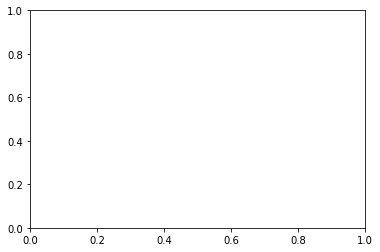

In [221]:
plt.scatter(dfRawByHourMean['activity1'].values,dfRawByHourMean.index.values, c = y_pred, s = 50 * dfRawByHourMean['activity3'].values) #s = dfRawRed['activity1'].values